TABLE OF CONTENT
  1. Import Libraries
  2. Calendar data
    2.1 Create a linechart
    2.2 Time-series analysis: decomposition
    2.3 Testing for stationarity
    2.4 Stationarizing
  3. Net Cold Rent Berlin 2005-2023
    3.1 Create a linechart
    3.2 Time-series analysis: decomposition
    3.3 Testing for stationarity

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') 

In [2]:
# Create path
path = r'/Users/Dulce/Dec2024 - Airbnb Berlin'

# 2. Calendar data

In [3]:
# Import 'final_selected' which contains only numerical variables
final_df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'final_df_2.pkl'))
final_df.reset_index(drop=True, inplace=True)
final_df.index = range(1, len(final_df) + 1)
final_df.columns

Index(['id', 'date', 'month', 'available', 'season', 'name', 'host_id',
       'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'calculated_host_listings_count',
       'availability_365', 'license', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'property_type',
       'accommodates', 'maximum_nights', 'first_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'Population',
       'Deficit housing', 'rental_simple_type', 'price_range',
       'accommodates_type', 'rental_type', 'review_level'],
      dtype='object')

In [4]:
final_df.dtypes

id                                        object
date                              datetime64[ns]
month                                     object
available                                 object
season                                    object
name                                      object
host_id                                   object
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                  object
longitude                                 object
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                               object
calculated_host_listings_count             int64
availability_365                           int64
license                                   object
host_response_time  

In [5]:
day_counts = final_df.groupby( final_df['date'].dt.date)['date'].count()
day_counts

date
2024-01-01    173
2024-01-02    173
2024-01-03    173
2024-01-04    173
2024-01-05    173
             ... 
2024-12-13    172
2024-12-14    172
2024-12-15    172
2024-12-16    172
2024-12-17    171
Name: date, Length: 352, dtype: int64

In [6]:
#avg price on day
avg_price_day = final_df.groupby('date')['price'].mean()
avg_price_day

date
2024-01-01    101.689443
2024-01-02    101.689443
2024-01-03    101.689443
2024-01-04    101.689443
2024-01-05    101.689443
                 ...    
2024-12-13    101.652754
2024-12-14    101.652754
2024-12-15    101.652754
2024-12-16    101.652754
2024-12-17    101.826162
Name: price, Length: 352, dtype: float64

In [7]:
final_df = pd.DataFrame({'date': day_counts.index, 'day_counts': day_counts.values, 'avg_price': avg_price_day.values})
final_df

,date,day_counts,avg_price
0,2024-01-01,173,101.689443
1,2024-01-02,173,101.689443
2,2024-01-03,173,101.689443
3,2024-01-04,173,101.689443
4,2024-01-05,173,101.689443
...,...,...,...
347,2024-12-13,172,101.652754
348,2024-12-14,172,101.652754
349,2024-12-15,172,101.652754
350,2024-12-16,172,101.652754


In [8]:
# Set the "Date" column as the index

from datetime import datetime

final_df['datetime'] = pd.to_datetime(final_df['date']) # Create a datetime column from "Date.""
final_df = final_df.set_index('datetime') # Set the datetime as the index of the dataframe.
final_df.drop(['date', 'day_counts'], axis=1, inplace=True) # Drop the "Date" column.
final_df.head()

,avg_price
datetime,
2024-01-01,101.689443
2024-01-02,101.689443
2024-01-03,101.689443
2024-01-04,101.689443
2024-01-05,101.689443


In [9]:
index_data_type = final_df.index.dtype
print("Data type of the index:", index_data_type)

Data type of the index: datetime64[ns]


In [10]:
final_df.dtypes

avg_price    float64
dtype: object

## 2.1 Create a linechart

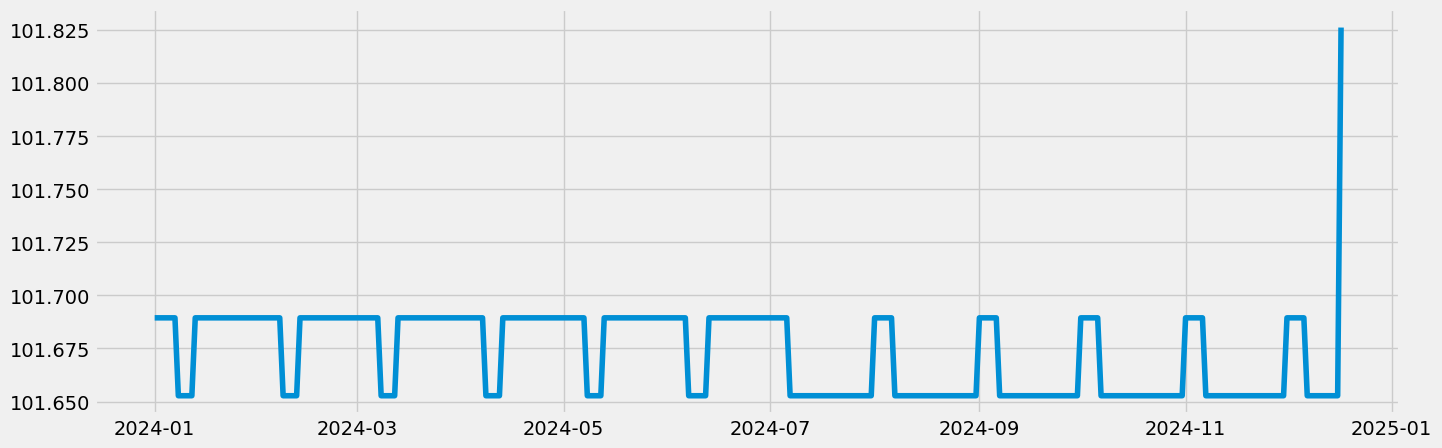

In [11]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(final_df)

## 2.2. Time-series analysis: decomposition

In [12]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(final_df, model='additive')

In [13]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

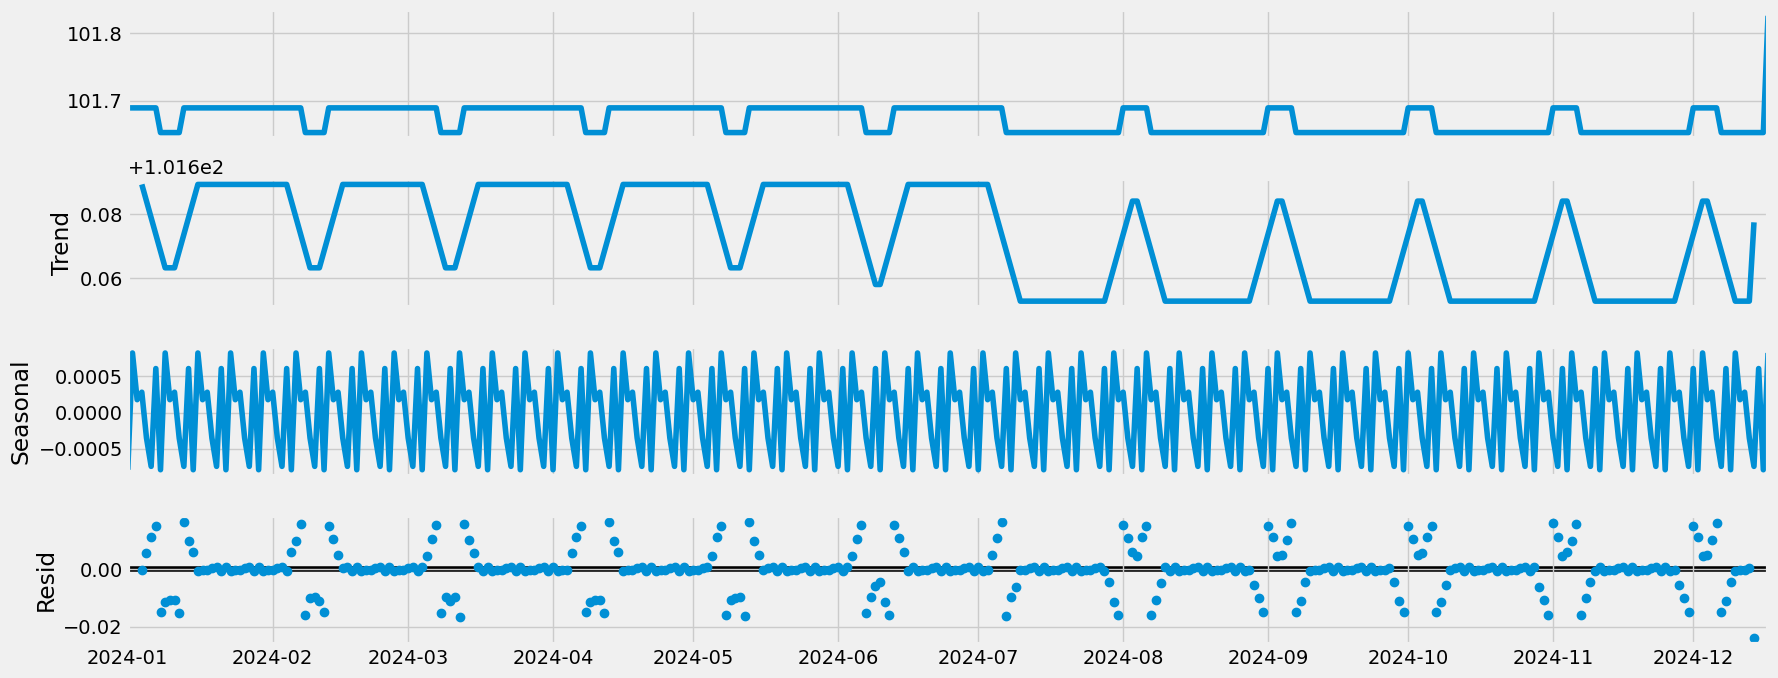

In [14]:
# Plot the separate components

decomposition.plot()
plt.show()

A trend refers to a long-term upward or downward movement in the overall direction of the points. The trend is decreasing but with peaks coming back to the previous value.
Seasonality refers to a pattern that repeats itself periodically at the same time each year. We see seasonal fluctuations represented by some spikey points that changes at a regular interval.
A noise stands for any variability in the data that can’t be explained by seasonality or cycles. There is many unexplained noises in the middle of the months where there are a number of up-and-down deviations.

## 2.3 Testing for stationarity

In [15]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(final_df['avg_price'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.505346
p-value                          0.114179
Number of Lags Used             11.000000
Number of Observations Used    340.000000
Critical Value (1%)             -3.449730
Critical Value (5%)             -2.870079
Critical Value (10%)            -2.571319
dtype: float64


Test Statistic (-2.5): It is the direct result of the statistical test
p-value: It indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05 and we have 0.11. So we can see our result is not significant.

Test Statistic (-2.5) > Critical Value (-3.4, -2.9, -2.6) --> We can’t reject null hypothesis

Null hypothesis = "There is presence of a unit root" --> We can´t disprove it, so we can say our data is no-stationary

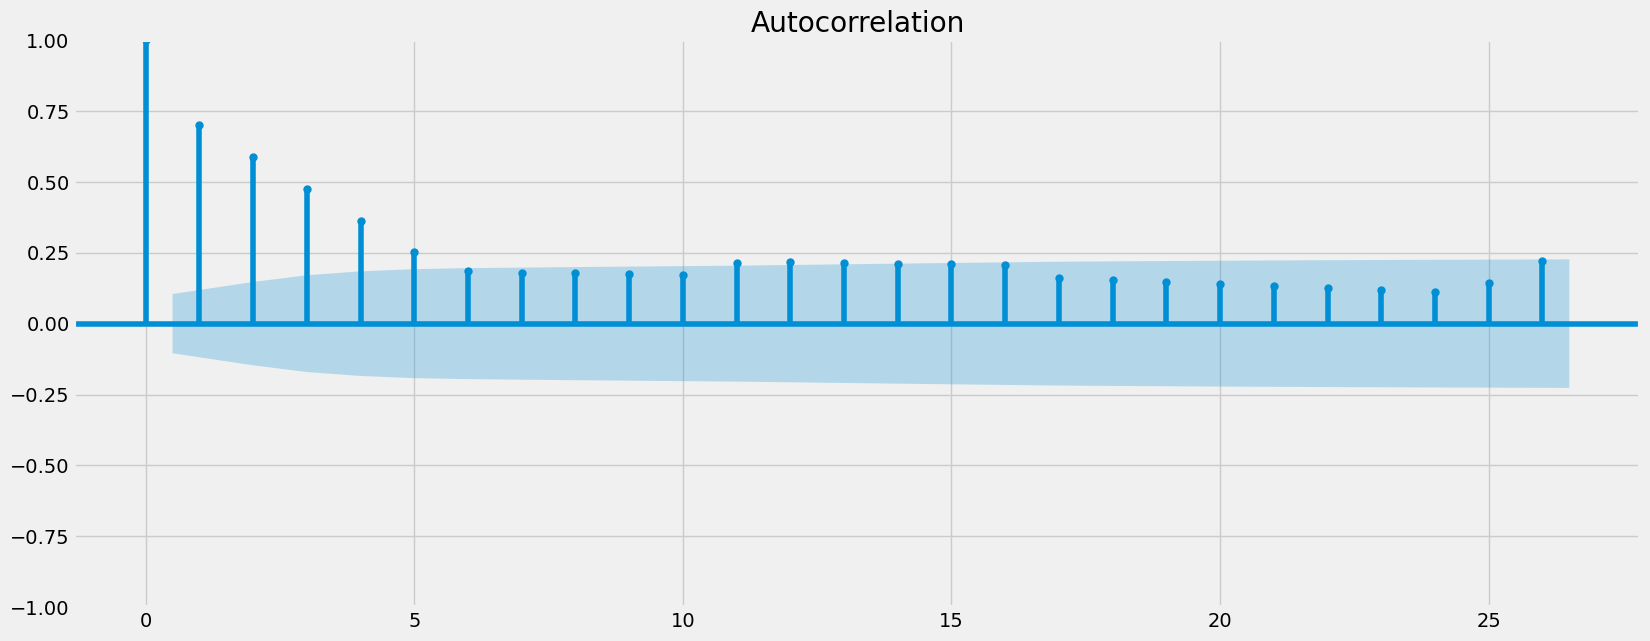

In [16]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(final_df)
plt.show()

We can test for autocorrelations by observing whether data points are linearly related to a lagged version of themselves. Autocorrelations are often non-stationary. As we can observe, our data has autocorrelations (as we suspected after the Dickey-Fuller Stationarity test). 

We have many lines below the blue interval, so we can deduce that the data is stationary but it is weak.

## 2.4 Stationarizing

In [17]:
data_diff = final_df - final_df.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [18]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [19]:
data_diff.head()

,avg_price
datetime,
2024-01-02,0.0
2024-01-03,0.0
2024-01-04,0.0
2024-01-05,0.0
2024-01-06,0.0


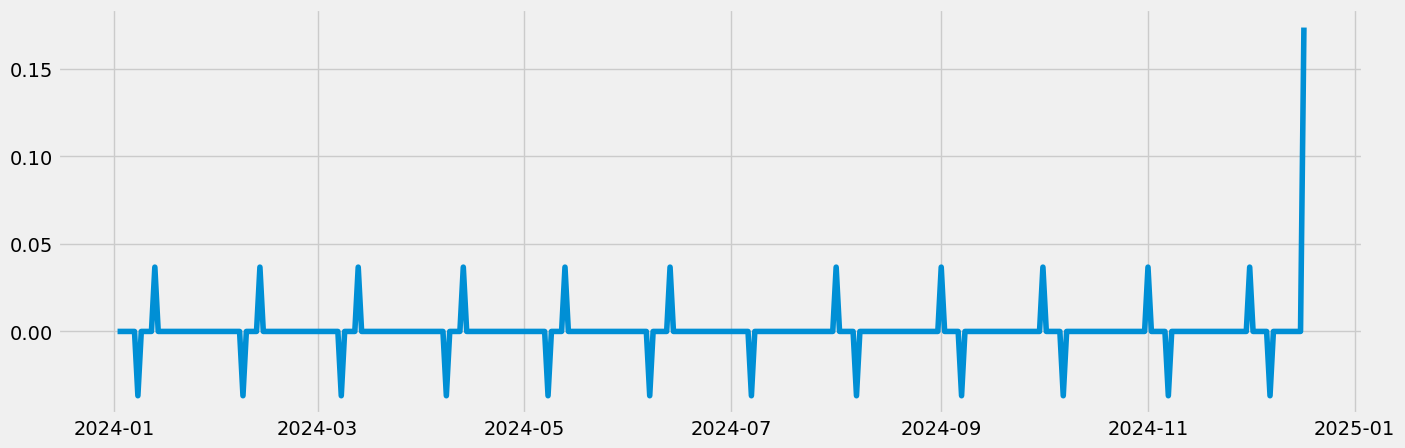

In [20]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [21]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.838883e+00
p-value                        1.812617e-09
Number of Lags Used            1.000000e+01
Number of Observations Used    3.400000e+02
Critical Value (1%)           -3.449730e+00
Critical Value (5%)           -2.870079e+00
Critical Value (10%)          -2.571319e+00
dtype: float64


Test Statistic (-6.8): It is the direct result of the statistical test
p-value: It indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05 and we have 0.000000001812617. So we can see our result is significant now.

Test Statistic (-6.8) < Critical Value (-3.4, -2.9, -2.6) --> We can reject null hypothesis

Null hypothesis = "There is presence of a unit root" --> We can disprove it, so we can say our data is now stationary

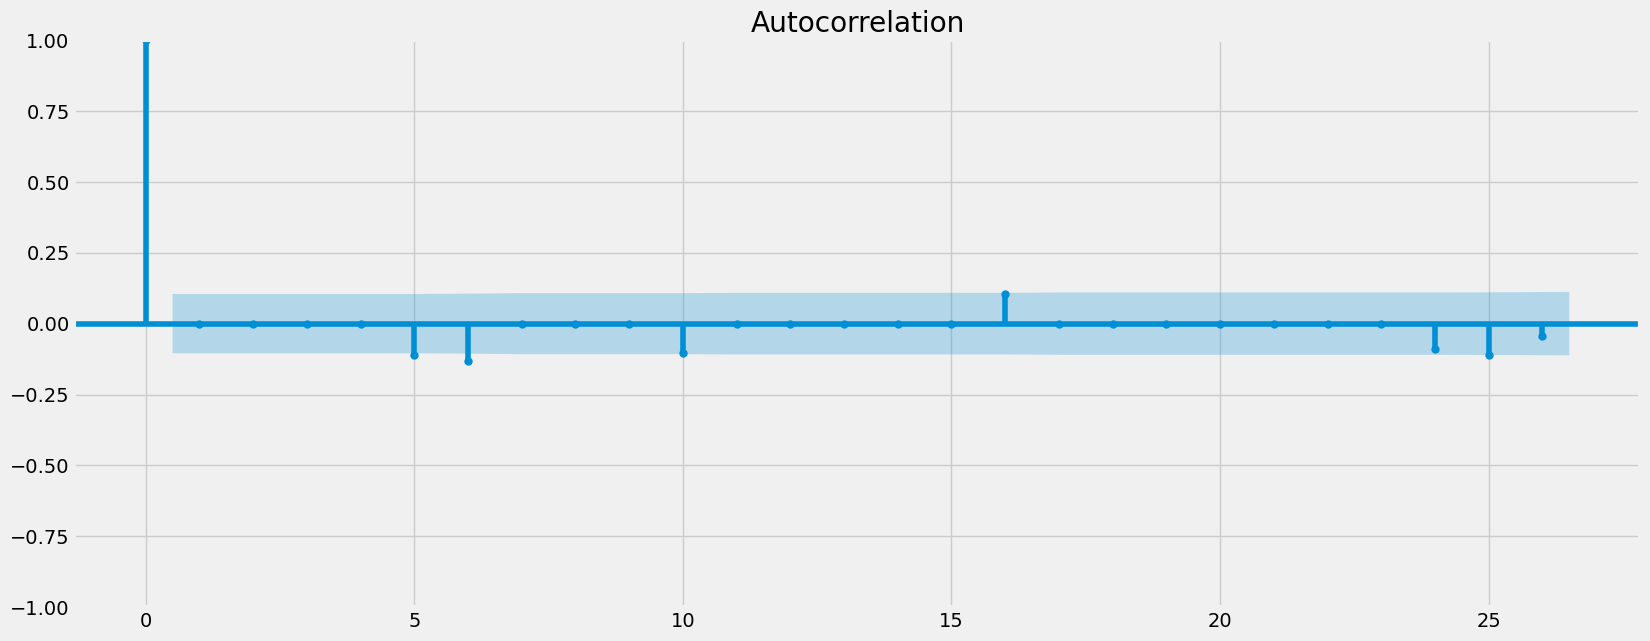

In [22]:
plot_acf(data_diff)
plt.show()

Now we have more lines below the blue area. But it is still one point beyond it, so we can agree it the data now is stationary but weak.

# 3. Net Cold Rent Data

In [23]:
# Import 'net cold rent'
rent = pd.read_csv(os.path.join(path, '02 Data', 'Original Data', 'net_rent.csv'), sep=";")
rent.head()

,date,net_cold_rent
0,1/1/05,79.2
1,1/2/05,79.2
2,1/3/05,79.2
3,1/4/05,79.4
4,1/5/05,79.3


In [24]:
rent.dtypes

date              object
net_cold_rent    float64
dtype: object

In [25]:
# Set the "Date" column as the index

from datetime import datetime

rent['datetime'] = pd.to_datetime(rent['date']) # Create a datetime column from "Date.""
rent = rent.set_index('datetime') # Set the datetime as the index of the dataframe.
rent.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
rent.head()

,net_cold_rent
datetime,
2005-01-01,79.2
2005-01-02,79.2
2005-01-03,79.2
2005-01-04,79.4
2005-01-05,79.3


In [26]:
index_data_type = rent.index.dtype
print("Data type of the index:", index_data_type)

Data type of the index: datetime64[ns]


In [27]:
rent['net_cold_rent'].dtype

dtype('float64')

## 3.1 Create a linechart

In [28]:
# Decompose the time series using an additive model
rent = rent.asfreq('D')
# Fill missing values with forward fill
rent = rent.fillna(method='ffill')

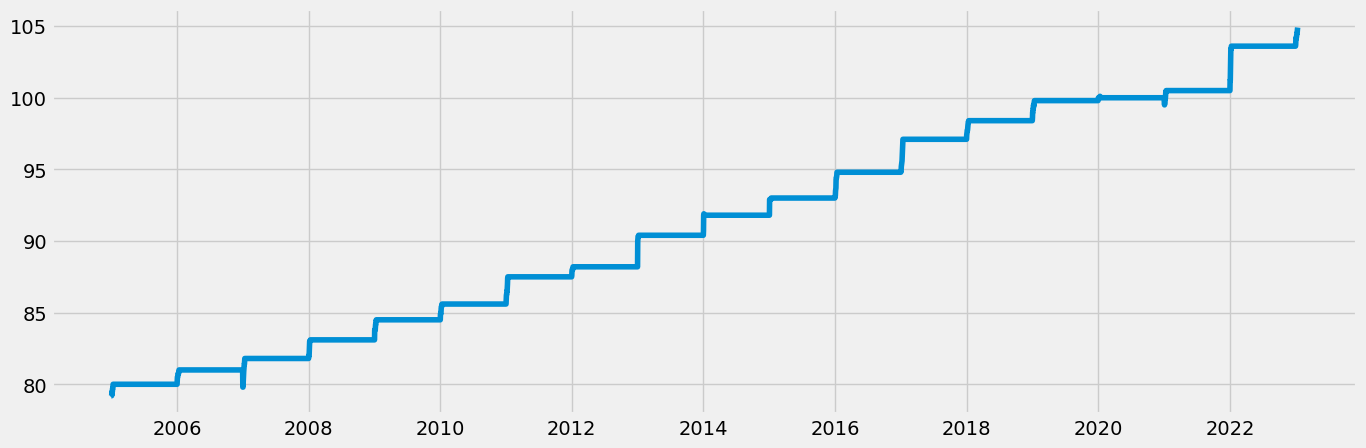

In [29]:
# Create a linechart
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(rent)

Tendency to increase.

## 3.2. Time-series analysis: decomposition

In [30]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(rent, model='additive')

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

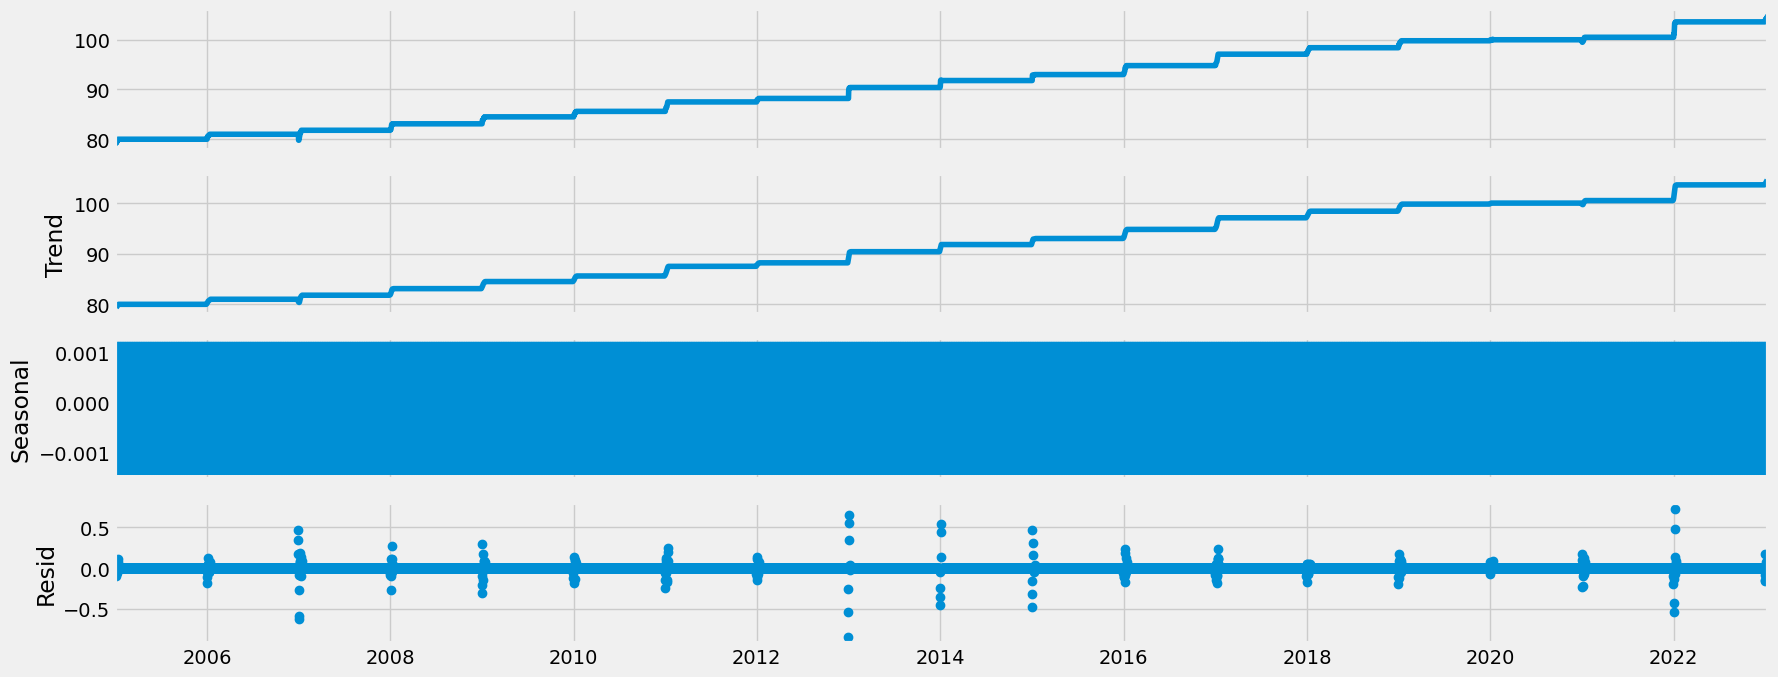

In [32]:
# Plot the separate components

decomposition.plot()
plt.show()

A trend has a long-term upward in the overall direction of the points. The trend is increasing with few peaks.
The seasonality line appears as a big horizontal bar, so it could indicate that the seasonality component is not changing much over time. In other words, the seasonal pattern is relatively constant throughout the entire time series. We can say there is no seasonality here.
A noise stands for any variability in the data that can’t be explained by seasonality or cycles. There is not many unexplained noises, just relevant in 2007, 2013-2015 and 2022.

## 3.3 Testing for stationarity

In [33]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(rent['net_cold_rent'])

Dickey-Fuller Stationarity test:
Test Statistic                    0.316672
p-value                           0.978097
Number of Lags Used              10.000000
Number of Observations Used    6575.000000
Critical Value (1%)              -3.431345
Critical Value (5%)              -2.861980
Critical Value (10%)             -2.567004
dtype: float64


Test Statistic (0.32): It is the direct result of the statistical test
p-value: It indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05 and we have 0.98. So we can see our result is not significant.

Test Statistic (0.32) > Critical Value (-3.4, -2.9, -2.6) --> We can’t reject null hypothesis

Null hypothesis = "There is presence of a unit root" --> We can´t disprove it, so we can say our data is no-stationary

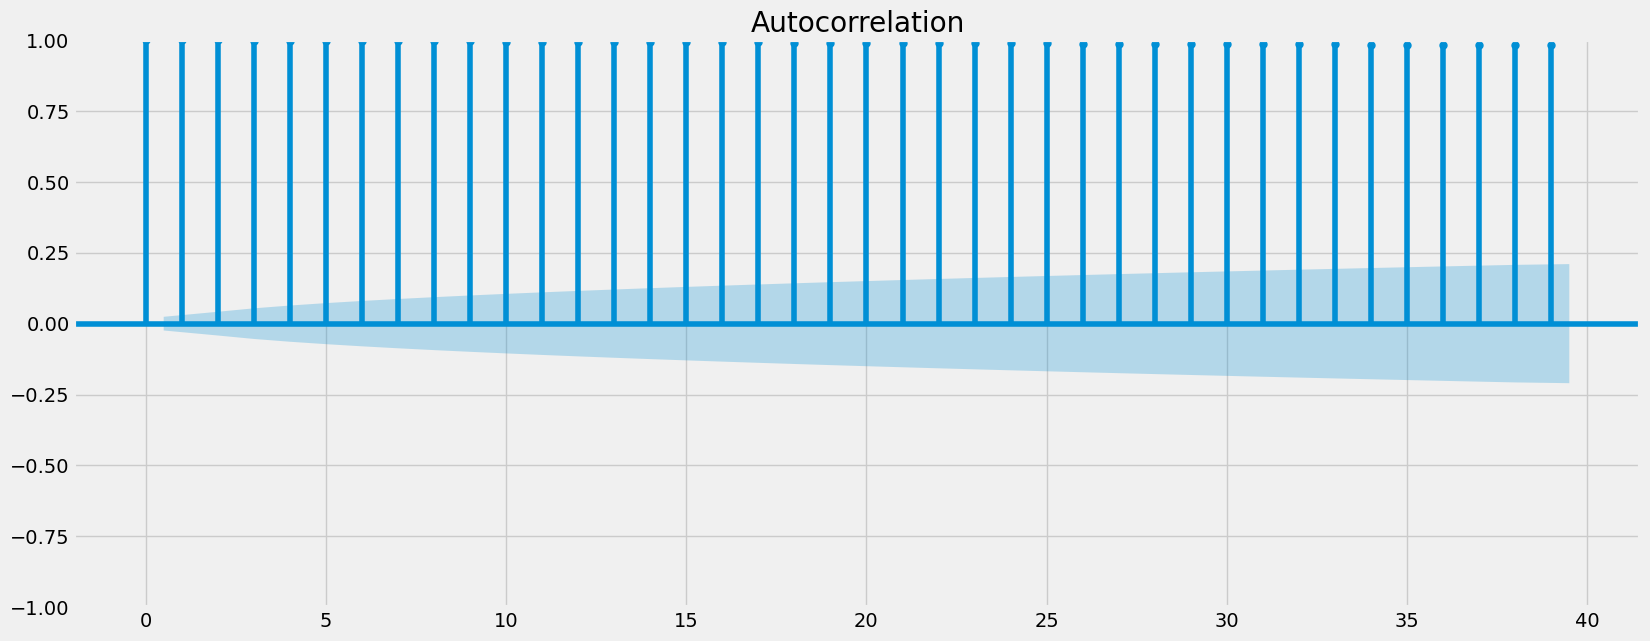

In [34]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(rent)
plt.show()

As we can observe, our data has many autocorrelations (as we suspected after the Dickey-Fuller Stationarity test). 

We have many lines below the blue interval, so we can deduce that the data is no-stationary.

## 3.4 Stationarizing

In [35]:
data_diff_rent = rent - rent.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff_rent.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
data_diff_rent.head()

,net_cold_rent
datetime,
2005-01-02,0.0
2005-01-03,0.0
2005-01-04,0.2
2005-01-05,-0.1
2005-01-06,0.2


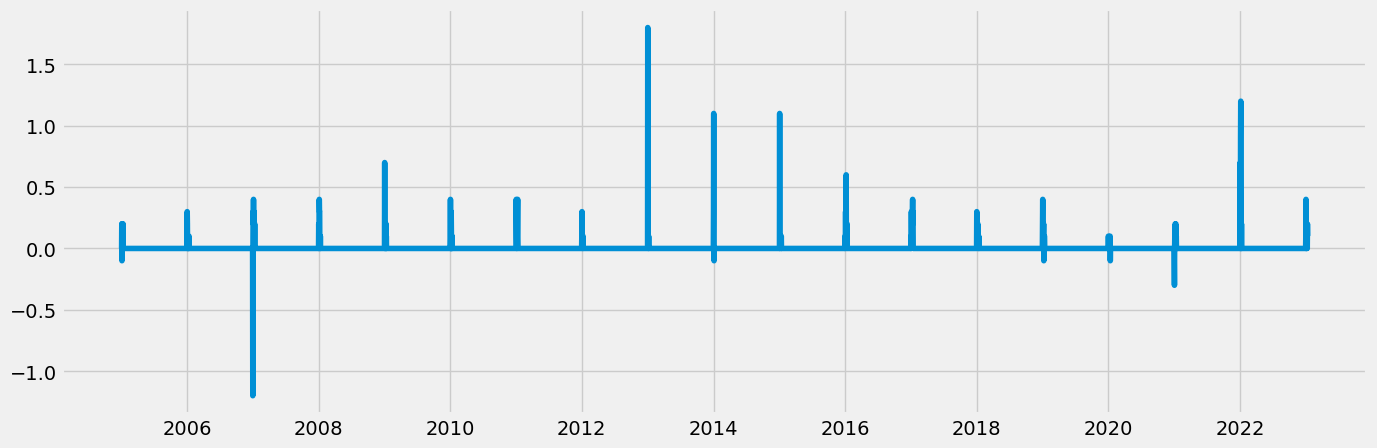

In [36]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_rent)

In [37]:
dickey_fuller(data_diff_rent)

Dickey-Fuller Stationarity test:
Test Statistic                  -22.814246
p-value                           0.000000
Number of Lags Used               9.000000
Number of Observations Used    6575.000000
Critical Value (1%)              -3.431345
Critical Value (5%)              -2.861980
Critical Value (10%)             -2.567004
dtype: float64


Test Statistic (-22.8): It is the direct result of the statistical test
p-value: It indicates whether the test result is significant. A “significant” result would be a p-value of less than 0.05 and we have 0.00. So we can see our result is significant now.

Test Statistic (-22.8) < Critical Value (-3.4, -2.9, -2.6) --> We can reject null hypothesis

Null hypothesis = "There is presence of a unit root" --> We can disprove it, so we can say our data is now stationary

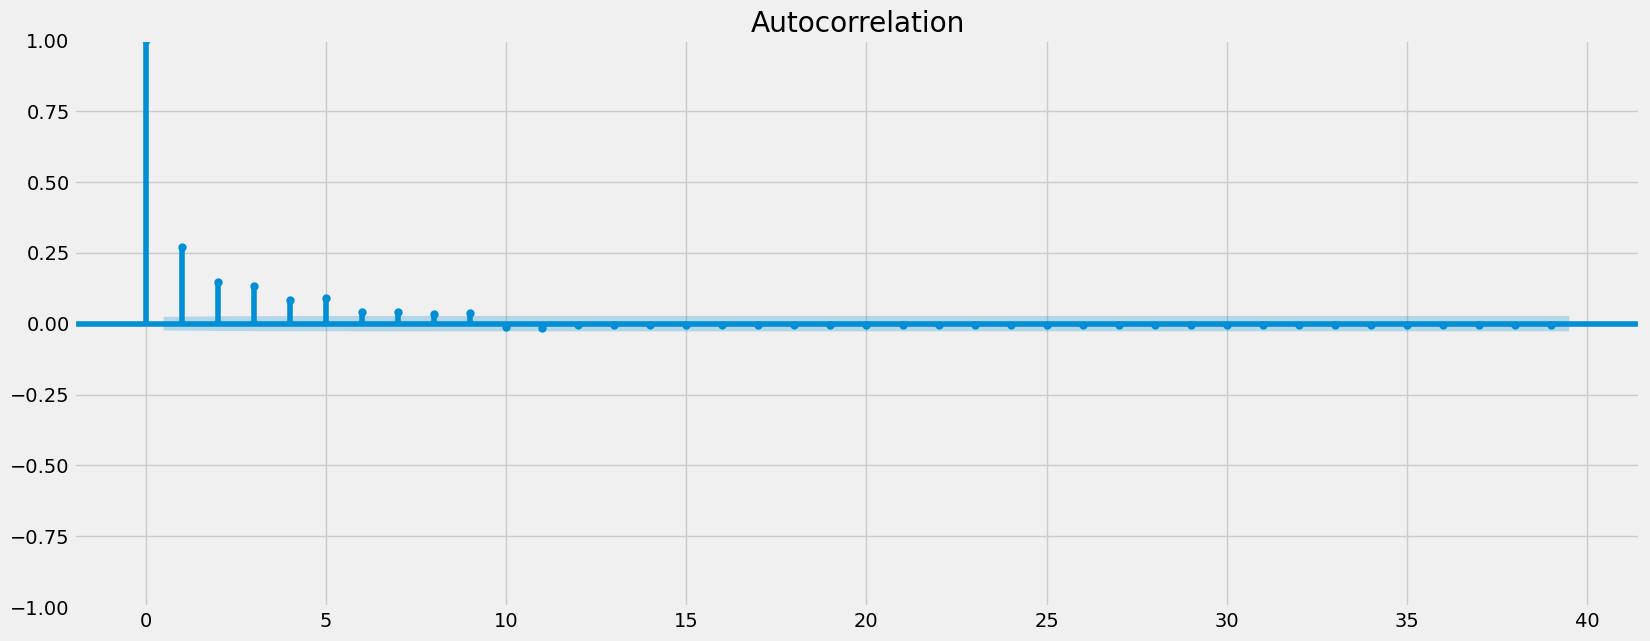

In [38]:
plot_acf(data_diff_rent)
plt.show()